In [68]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [ ]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

# Reconocimiento de dígitos con KNN



Definir los path al ejecutable de python 3.6 y sus librerías,
de acuerdo al virtual env que estén corriendo.

In [70]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import metnum


/home/gianluca/Documents/Metodos Numericos/github_grupal/metodos-num/tp2/notebooks
Python 3.8.5


In [ ]:
def pca(alpha, train,validacion):
    pca= metnum.PCA(alpha)
    pca.fit(train)
    train_pca = pca.transform(train)
    val_pca = pca.transform(validacion)
    return train_pca, val_pca


In [69]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, cohen_kappa_score, precision_score

def trainYvalidacion(k,X,y,X_val,y_val):

    clf = metnum.KNNClassifier(k)
    clf.fit(X, y)
    y_pred = clf.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    print("Accuracy: {}".format(acc))
    recall    = recall_score(y_val, y_pred,average = None)
    precision = precision_score(y_val, y_pred, average=None)
    f1        = f1_score(y_val, y_pred, average = None)
    return acc,recall,precision, f1,y_pred

In [ ]:
def numpy_to_csv(x,val,alpha,nset):
    df_x = pd.DataFrame(data=x)
    df_x.to_csv(f"transformaciones/{nset}_{alpha}_train.csv",index=False)
    df_val = pd.DataFrame(data=val)
    df_val.to_csv(f"transformaciones/{nset}_{alpha}_val.csv",index=False)

In [ ]:
%load_ext autoreload
%autoreload 2

df_train = pd.read_csv("../data/train.csv")
print(df_train.info())

X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)

X.shape, y.shape

# Experimento Preliminar 

Analizamos sobre una particion del dataset (5000) con el objetivo de conseguir una primera intuición con respecto al metodo.

In [ ]:

#Mezclamos la data original
idx = np.random.permutation(len(X))
X,y = X[idx], y[idx]
#Tomamamos los primeros 5000 datos
X,y = X[:5000],y[:5000]
X.shape,y.shape

In [ ]:
limit = int(0.8 * X.shape[0]) 

X_train, y_train = X[:limit], y[:limit]
X_val, y_val = X[limit:], y[limit:]

assert len(X_train) == len(y_train)
assert len(X_val) == len(y_val)

print(f"Ahora tengo {len(X_train)} instancias de entrenamiento y {len(X_val)} de validación")

In [ ]:
k_max = 300
salto_k = 10

Ks = [1] + [i*salto_k for i in range(1,int(k_max/salto_k) + 1)]
#Ks

In [ ]:
from timeit import default_timer as timer
start = timer()

accuracy = []
for k in Ks :
        
    clf = metnum.KNNClassifier(k)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    
    acc = accuracy_score(y_val, y_pred)
    accuracy.append(acc)
    if k%5 ==0 :
        print(f"Calculando k = {k}")
        
end = timer()
print(end - start)

In [ ]:
dat = pd.DataFrame({"K":Ks,"Accuracy": accuracy})
dat.sort_values(by=['Accuracy'],ascending = False).head(20)

In [ ]:
#Guardar csv
dat.to_csv("exp_csv/PreliminarValidacionSimple_knn.csv",index = True,header = True)

Como podemos notar a mediada que el k asciende su accuracy disminuye

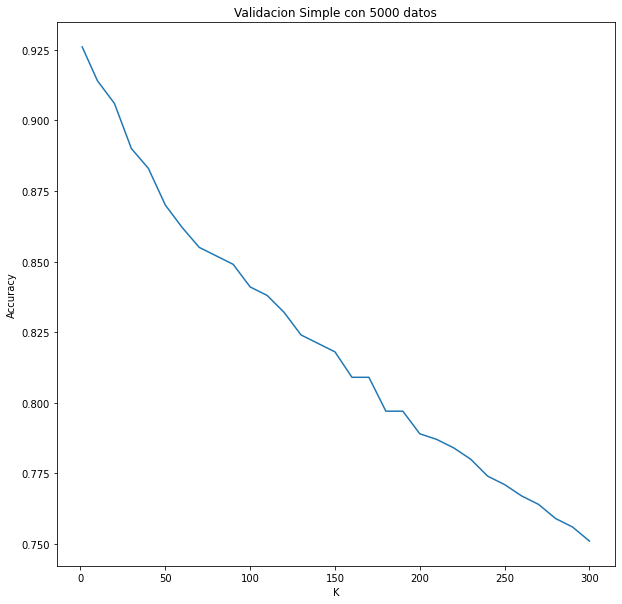

In [36]:
df = pd.read_csv("exp_csv/PreliminarValidacionSimple_knn.csv")
plt.figure(figsize=(10,10))
plt.ylabel("Accuracy")
plt.xlabel("K")
plt.title("Validacion Simple con 5000 datos")
sns.lineplot(x = df['K'], y = df['Accuracy'])
#plt.savefig("exp_csv/plots/validacionSimple_knnsolo.png")
plt.show()

Analizamos que sucede para los valores mas bajos de K 

In [ ]:
k_max = 30
salto_k = 1

Ks = [1] + [i*salto_k for i in range(1,int(k_max/salto_k) + 1)]
#Ks

In [ ]:
from timeit import default_timer as timer
start = timer()

accuracy = []
for k in Ks :
        
    clf = metnum.KNNClassifier(k)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    
    acc = accuracy_score(y_val, y_pred)
    accuracy.append(acc)
    if k%5 ==0 :
        print(f"Calculando k = {k}")
        
end = timer()
print(end - start)

In [ ]:
df_kchicos = pd.DataFrame({"K":Ks,"Accuracy": accuracy})
#Guardar csv
df_kchicos.to_csv("exp_csv/PreliminarValidacionSimple_knnCHICOS.csv",index = True,header = True)
df_kchicos.sort_values(by=['Accuracy'],ascending = False).head(20)

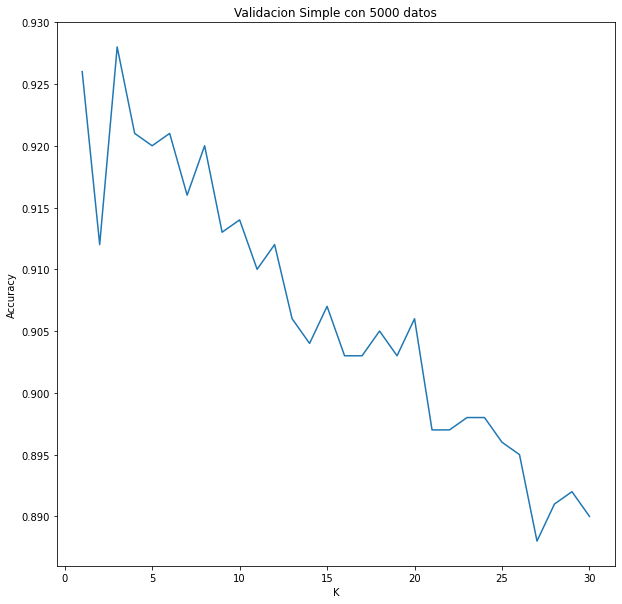

In [37]:
df = pd.read_csv("exp_csv/PreliminarValidacionSimple_knnCHICOS.csv")
plt.figure(figsize=(10,10))
plt.ylabel("Accuracy")
plt.xlabel("K")
plt.title("Validacion Simple con 5000 datos")
sns.lineplot(x = df['K'], y = df['Accuracy'])
#plt.savefig("exp_csv/plots/validacionSimple_knnsolo_Kchicos.png")
plt.show()

# Accuracy validacion simple sobre el dataset completo

Buscamos las mejores parejas sobre un rango amplio de alpha y k , utilizando un split simple de 33600 instancias de entrenamiento y 8400 de validación.


In [59]:
%load_ext autoreload
%autoreload 2

df_train = pd.read_csv("../data/train.csv")
print(df_train.info())

X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)

#Mezclamos la data original
np.random.seed(30)
idx = np.random.permutation(len(X))
X,y = X[idx], y[idx]

X.shape,y.shape

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None


((42000, 784), (42000, 1))

In [60]:
limit = int(0.8 * X.shape[0]) 

X_train, y_train = X[:limit], y[:limit]
X_val, y_val = X[limit:], y[limit:]

assert len(X_train) == len(y_train)
assert len(X_val) == len(y_val)

print(f"Ahora tengo {len(X_train)} instancias de entrenamiento y {len(X_val)} de validación")


Ahora tengo 33600 instancias de entrenamiento y 8400 de validación


In [61]:
k_max = 30

Ks = [i for i in range(1,k_max+1)]
Ks

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30]

In [ ]:
from timeit import default_timer as timer
start = timer()

accuracy = []
for k in Ks :
        
    clf = metnum.KNNClassifier(k)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    
    acc = accuracy_score(y_val, y_pred)
    accuracy.append(acc)
    if k%5 ==0 :
        print(f"Calculando k = {k}")
        
end = timer()
print(end - start)

In [ ]:
val_simple = pd.DataFrame({"K":Ks,"Accuracy": accuracy})

In [ ]:
#Guardar csv
val_simple.to_csv("exp_csv/ValidacionSimple_knn.csv",index = True,header = True)

In [62]:
#Leer csv ya guardado
val_simple = pd.read_csv("exp_csv/ValidacionSimple_knn.csv")

In [63]:
val_simple.sort_values(by= ["Accuracy"],ascending = False)

,K,Accuracy
2,3,0.971190
3,4,0.970357
4,5,0.969643
5,6,0.969524
6,7,0.968929
7,8,0.968690
0,1,0.967500
9,10,0.967500
8,9,0.967024
10,11,0.965714


# Cross Validation

Extraemos de la validacion simple los parametros de las mejores 5 parejas para luego hacer CV con ellas.

In [65]:
val_simple.sort_values(by=['Accuracy'],ascending = False).head(10)

,K,Accuracy
2,3,0.971190
3,4,0.970357
4,5,0.969643
5,6,0.969524
6,7,0.968929
7,8,0.968690
0,1,0.967500
9,10,0.967500
8,9,0.967024
10,11,0.965714


In [66]:
mejores_k = val_simple.sort_values(by=['Accuracy'],ascending = False).head(10)["K"].unique()
mejores_k = list(map(int, mejores_k))
mejores_k.sort()
mejores_k

[1, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, recall_score, f1_score, cohen_kappa_score, precision_score

def work(X, y, clf, k):

    accuracy = []
    recall = np.zeros(10)
    precision = np.zeros(10)
    f1 = np.zeros(10)

    kf = KFold(n_splits=k)
    i = 1
    for train_index, test_index in kf.split(X):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        accuracy.append(accuracy_score(y_test, y_pred))
        recall    += recall_score(y_test, y_pred,average = None)
        precision += precision_score(y_test, y_pred, average=None)
        f1        += f1_score(y_test, y_pred, average = None)
        
        i += 1
    
    recall /= k
    precision /= k
    f1 /= k
    return np.mean(accuracy),recall,precision, f1

In [ ]:
kfold = 10

In [ ]:
from timeit import default_timer as timer
start = timer()

recall_cv = np.zeros((len(mejores_k),10))
precision_cv = np.zeros((len(mejores_k),10))
f1_cv = np.zeros((len(mejores_k),10))

col_k = []
accuracy = []

i = 0

for k in mejores_k :

    clf = metnum.KNNClassifier(k)
    info = work(X_train, y_train, clf, kfold)

    recall_cv[i] = info[1]
    precision_cv[i] = info[2]
    f1_cv[i] = info[3]

    #para armar dsp el heatmap
    accuracy.append(info[0])
    col_k.append(k)

    
    print(f"Calculando k = {k}")
    i += 1

        
end = timer()
print(end - start)

In [ ]:
rec = pd.DataFrame(data = recall_cv)
rec.insert(0, "K", col_k , True) 
rec.to_csv("exp_csv/recall_cv_knn.csv",index = False,header = True)

preci = pd.DataFrame(data = precision_cv)
preci.insert(0, "K", col_k , True) 
preci.to_csv("exp_csv/precision_cv_knn.csv",index = False,header = True)


f1 = pd.DataFrame(data = f1_cv)
f1.insert(0, "K", col_k , True) 
f1.to_csv("exp_csv/f1_cv_knn.csv",index = False,header = True)

In [ ]:
dfCV = pd.DataFrame({"K":col_k,"Accuracy": accuracy})
dfCV.to_csv("exp_csv/CrossValidation_knn.csv",index = False,header = True)


In [44]:
# LEER CSV METRICAS
rec_Cv = pd.read_csv("exp_csv/recall_cv_knn.csv")
preci_Cv = pd.read_csv("exp_csv/precision_cv_knn.csv")
f1_Cv = pd.read_csv("exp_csv/f1_cv_knn.csv")

print("Recall Cross validation:")
display(rec_Cv)
print("Precision Cross validation:")
display(preci_Cv)
print("F1 Cross validation:")
display(f1_Cv)

Recall Cross validation:


,K,0,1,2,3,4,5,6,7,8,9
0,3,0.992810,0.992816,0.952542,0.960769,0.956093,0.954594,0.987850,0.975864,0.930550,0.961850
1,4,0.991224,0.992581,0.950391,0.955941,0.945009,0.956774,0.989729,0.971097,0.934531,0.972583
2,5,0.992776,0.993377,0.949873,0.962236,0.956637,0.954957,0.988178,0.970494,0.929005,0.965964
3,6,0.993328,0.993688,0.943244,0.957259,0.948306,0.954813,0.989394,0.970220,0.931295,0.969838
4,7,0.992733,0.994457,0.945448,0.960139,0.953505,0.955376,0.987556,0.971665,0.924556,0.962658
5,1,0.991609,0.994976,0.959656,0.956208,0.956526,0.951835,0.985119,0.970320,0.931315,0.951171
6,8,0.992172,0.994139,0.944626,0.956222,0.949924,0.955163,0.988763,0.967463,0.926429,0.960959
7,9,0.992755,0.994411,0.943492,0.958526,0.955185,0.952877,0.985698,0.969187,0.920842,0.955362
8,10,0.992105,0.994135,0.942330,0.956165,0.949098,0.951842,0.987230,0.966835,0.925477,0.958890
9,11,0.991801,0.994668,0.939531,0.958172,0.953366,0.952853,0.986019,0.964744,0.918993,0.956751


Precision Cross validation:


,K,0,1,2,3,4,5,6,7,8,9
0,3,0.980932,0.962361,0.987544,0.968145,0.977412,0.964229,0.971651,0.956389,0.979620,0.928588
1,4,0.984152,0.963562,0.985387,0.973215,0.984019,0.959720,0.968003,0.957978,0.978538,0.917407
2,5,0.978792,0.954261,0.985101,0.966972,0.983253,0.963120,0.969720,0.957312,0.982809,0.934859
3,6,0.980960,0.955193,0.987669,0.968651,0.984401,0.964329,0.968565,0.954431,0.979067,0.922225
4,7,0.978851,0.948761,0.985905,0.962864,0.982632,0.963311,0.968830,0.957380,0.981799,0.931705
5,1,0.978874,0.965106,0.981026,0.950661,0.972504,0.957018,0.975088,0.960938,0.980068,0.935764
6,8,0.977665,0.948140,0.985601,0.964656,0.984237,0.958558,0.971606,0.952138,0.983487,0.922943
7,9,0.975031,0.942221,0.984406,0.961687,0.982992,0.958525,0.971243,0.950850,0.986067,0.929750
8,10,0.974968,0.942373,0.985366,0.962728,0.984102,0.961595,0.969500,0.952346,0.983845,0.922324
9,11,0.974679,0.936370,0.985035,0.959821,0.983350,0.960089,0.969787,0.951984,0.986027,0.926650


F1 Cross validation:


,K,0,1,2,3,4,5,6,7,8,9
0,3,0.986813,0.977332,0.969660,0.964379,0.966566,0.959314,0.979668,0.965932,0.954389,0.944908
1,4,0.987661,0.977841,0.967485,0.964423,0.964086,0.958211,0.978729,0.964395,0.955967,0.944150
2,5,0.985711,0.973402,0.967085,0.964512,0.969721,0.958964,0.978847,0.963728,0.955087,0.950110
3,6,0.987096,0.974041,0.964873,0.962857,0.965999,0.959488,0.978859,0.962127,0.954520,0.945394
4,7,0.985726,0.971045,0.965206,0.961421,0.967807,0.959267,0.978090,0.964383,0.952280,0.946909
5,1,0.985173,0.979780,0.970199,0.953375,0.964421,0.954367,0.980053,0.965558,0.955035,0.943329
6,8,0.984841,0.970562,0.964638,0.960377,0.966733,0.956711,0.980100,0.959668,0.954080,0.941467
7,9,0.983795,0.967571,0.963481,0.960070,0.968869,0.955571,0.978410,0.959878,0.952300,0.942286
8,10,0.983441,0.967524,0.963338,0.959391,0.966241,0.956574,0.978268,0.959484,0.953715,0.940138
9,11,0.983140,0.964590,0.961703,0.958939,0.968105,0.956332,0.977816,0.958268,0.951286,0.941363


In [38]:
cv = pd.read_csv("exp_csv/CrossValidation_knn.csv")
cv

,K,Accuracy
0,3,0.967143
1,4,0.966488
2,5,0.966875
3,6,0.965655
4,7,0.965357
5,1,0.965417
6,8,0.964048
7,9,0.963333
8,10,0.962917
9,11,0.962232


In [53]:
bestK_cv = cv.sort_values(by =["Accuracy"],ascending = False).head(1)["K"].to_list()[0]
print(f"Mejor K de cross validation : {bestK_cv} ")


Mejor K de cross validation : 3 


# Train y test con la mejor pareja de Cross Validation


In [71]:
acc,recall,precision,f1,pred = trainYvalidacion(bestK_cv,X_train,y_train,X_val,y_val)

Accuracy: 0.9661904761904762


Ponemos ceros en la diagonal para visualizar mejor el heatmap

In [72]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val,pred,normalize = "true")

np.fill_diagonal(cm, 0, wrap=False)

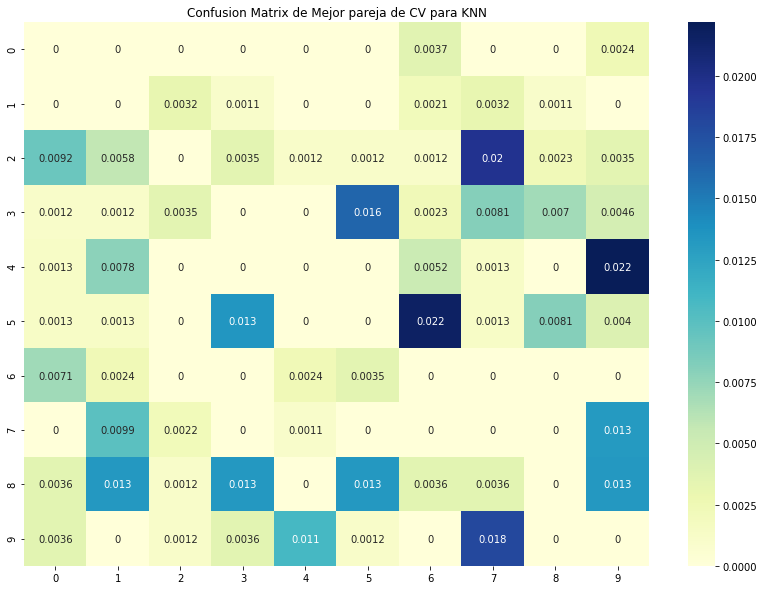

In [73]:
plt.figure(figsize=(14,10))
sns.heatmap(cm,cmap = "YlGnBu",annot = True)
plt.title("Confusion Matrix de Mejor pareja de CV para KNN")
plt.show()

# Prestar atencion a la escala de cada ploteo , se encuentran de tal manera de modo que se visualicen mejor por separado.

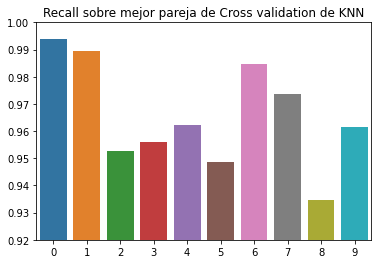

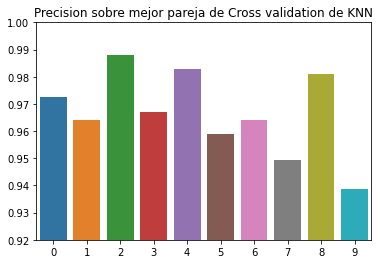

In [74]:
import matplotlib.pyplot as plt
ejex = [i for i in range(10)]
sns.barplot(x = ejex , y = recall)
plt.ylim(0.92, 1)
plt.title("Recall sobre mejor pareja de Cross validation de KNN")
plt.show()
sns.barplot(x = ejex , y = precision)
plt.ylim(0.92, 1)
plt.title("Precision sobre mejor pareja de Cross validation de KNN")
plt.show()